### Simulation: Masternode Yield Farming

In [1]:
import os
import copy
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from IPython.display import Image
cwd =  os.getcwd().replace("notebooks/research/impermanent_loss","")
os.chdir(cwd)

from python.dev.helper import Helper

from python.dev.simulation import SimulationOrchestrator
from python.dev.simulation import EventQueue
from python.dev.simulation import EventExecutor
from python.dev.simulation.batch import ActionBatch
from python.dev.simulation.batch import MergeBatch

from python.dev.agent import TokenAgent
from python.dev.agent import LPTokenAgent
from python.dev.agent import UserAgent

from python.dev.action import MintAction
from python.dev.action import DepositAction
from python.dev.action import LPDepositChainAction
from python.dev.action import DepositChainAction
from python.dev.action import WithdrawChainAction
from python.dev.action import WithdrawAction
from python.dev.action import SwapAction
from python.dev.event import Mint
from python.dev.event import Deposit
from python.dev.event import Withdraw
from python.dev.event import Swap

from python.dev.math.model import BrownianModel
from python.dev.math.model import TokenDeltaModel
from python.dev.math.model import TimeDeltaModel
from python.dev.math.model import ModelQueue
from python.dev.math.model import EventSelectionModel

from python.dev.lp import LiquidityPool
from python.dev.lp.event import LPEvent
from python.dev.lp.event import MintLPEvent
from python.dev.lp.event import DepositLPEvent
from python.dev.lp.event import SwapLPEvent

In [2]:
from python.dev.cpt import Liquidity
import scipy.special as sps 

class SimulateLiquidity():
    
    def __init__(self, x_real, y_real, x_name, y_name, max_trade = 1000):       
        self.liq_obj = Liquidity(x_real, y_real, x_name, y_name)
        self.max_trade = max_trade
        self.shape = None
        self.scale = None

    def get_max_trade(self):
        return self.max_trade       
        
    def get_liquidity_obj(self):
        return self.liq_obj
        
    def set_params(self):
        self.shape, self.scale = 1, self.max_trade/5    
        
    def gen_delta_y(self):    
        self.set_params()
        return np.random.gamma(self.shape, self.scale)
    
    def gen_new_position(self, p):
        delta_y = self.gen_delta_y()
        delta_x = (self.liq_obj.get_y_real() + delta_y)/p - self.liq_obj.get_x_real()
        self.liq_obj.add_delta_y(delta_y)
        self.liq_obj.add_delta_x(delta_x)   
        
    def apply(self, p_arr):
        delta_x_arr = np.array([])
        delta_y_arr = np.array([])
        for p in p_arr: 
            self.gen_new_position(p)
            delta_x_arr = np.append(delta_x_arr,self.liq_obj.get_x_delta()) 
            delta_y_arr = np.append(delta_y_arr,self.liq_obj.get_y_delta()) 
            
        return delta_x_arr, delta_y_arr    

In [3]:
def gen_xy_value(p, x_mu_deposit, sigma=1):
    y_mu_deposit = p*x_mu_deposit
    #x_deposit_value = np.random.normal(x_mu_deposit, sigma)
    #y_withdraw_value = np.random.normal(y_mu_deposit, sigma)
    x_deposit_value = x_mu_deposit
    y_withdraw_value = y_mu_deposit    
    xy_values = np.array((x_deposit_value, y_withdraw_value))
    return xy_values


def gen_xy_arr(p_arr, x_mu_deposit=1, sigma=1):
    xy_vals_arr = np.array([])
    for p in p_arr:
        xy_vals = gen_xy_value(p, x_mu_deposit, sigma)
        if len(xy_vals_arr) == 0:
            xy_vals_arr = np.array(xy_vals) 
        else:
            xy_vals_arr = np.vstack((xy_vals_arr,xy_vals))
            
    return xy_vals_arr

### Initialize Agents

In [4]:
USER1 = UserAgent('USER1')
SYS = TokenAgent('SYS')
DAI = TokenAgent('DAI')
SYS_DAI_LP = LiquidityPool('SYS/DAI', USER1, SYS, DAI)
SYS_DAI = LPTokenAgent('SYS_DAI_LP', SYS_DAI_LP)

### Mint Tokens

In [5]:
apy = 0.1
t_delta = 109*24*3600
N_RUNS = 5*365

In [6]:
SYS_mint1 = Mint(5000000, apy, True)
DAI_mint1 = Mint(1000000, apy, True)
SYS_DAI_LP_mint1 = Mint(0, apy, True)

m_action1 = MintAction(SYS_mint1, SYS, USER1)
m_action2 = MintAction(DAI_mint1, DAI, USER1)
m_action3 = MintAction(SYS_DAI_LP_mint1, SYS_DAI, USER1)

In [7]:
sBatch = ActionBatch('SETUP1')
sBatch.init_action(m_action1)
sBatch.init_action(m_action2)
sBatch.init_action(m_action3)

setup_batch = sBatch.generate()

In [8]:
sBatch.inspect()

** SETUP1 INIT BATCH **
USER1 MINTs 5000000.00 SYS 
USER1 MINTs 1000000.00 DAI 
USER1 MINTs 0.00 SYS_DAI_LP 


### Setup Actions

### Batchset 2

In [9]:
t_delta_model = TimeDeltaModel().apply(p = 0.00001, n = N_RUNS)
t_delta_obj3 = ModelQueue().apply(t_delta_model)
t_delta_obj4 = ModelQueue().apply(t_delta_model)

In [10]:
N_RUNS = 1825

In [11]:
b = BrownianModel(0.2)
p_arr = b.gen_gbm(0.1, 1, N_RUNS, 1)
xy_arr = gen_xy_arr(p_arr, 100, 10)

sim_liq = SimulateLiquidity(1000, 200, 'SYS','DIA')
x_delta, y_delta = sim_liq.apply(p_arr)

r_deposit_model = np.random.normal(100, 10, N_RUNS)
r_withdraw_model = np.random.normal(20, 10, N_RUNS)

#r_deposit_model = np.abs(x_delta)
#r_withdraw_model = y_delta

In [12]:
#r_deposit_model = x_delta[:10]
#r_withdraw_model = y_delta[:10]

In [13]:
r_withdraw_obj1 = ModelQueue().apply(r_deposit_model)
r_withdraw_obj2 = ModelQueue().apply(r_deposit_model)

In [14]:
#deposit_event1 = Deposit(apy, r_deposit_obj1, t_delta_obj3) 
#deposit_event2 = Deposit(apy, r_deposit_obj2, t_delta_obj4) 

withdraw_event1 = Withdraw(apy, r_withdraw_obj1, t_delta_obj3) 
withdraw_event2 = Withdraw(apy, r_withdraw_obj2, t_delta_obj4) 

In [15]:
# Deposit SYS
#d_action1 = DepositAction(deposit_event1, SYS, USER1, SYS_mint1.get_id())
#d_action2 = DepositAction(deposit_event2, DAI, USER1, DAI_mint1.get_id())

w_action1 = WithdrawAction(withdraw_event1, SYS, USER1, SYS_mint1.get_id())
w_action2 = WithdrawAction(withdraw_event2, DAI, USER1, DAI_mint1.get_id())

d_action3 = LPDepositChainAction(w_action1, w_action2, SYS_DAI, USER1, SYS_DAI_LP_mint1.get_id())



In [16]:
aBatch = ActionBatch('RUN1', N_RUNS)
aBatch.add_action(w_action1)
aBatch.add_action(w_action2)
aBatch.add_action(d_action3)
action_batch = aBatch.generate()

In [17]:
#aBatch.inspect()


### Setup event queue

In [18]:
q = EventQueue()
q.add_setup_batch(setup_batch)
q.add_action_batch(action_batch)
q.freeze()

### Execute events

In [19]:
all_batches = q.get_all_batches()

orchestrator = SimulationOrchestrator(verbose = False)
executor = EventExecutor(q, orchestrator)
executor.run()

In [20]:
#orchestrator.print_logs()

### Analyze

In [21]:
tSYS = SYS.get_token()
tDAI = DAI.get_token()
tSYS_DAI = SYS_DAI.get_token()

SYS_addr1 = SYS.get_address(SYS_mint1.get_id())
DAI_addr1 = DAI.get_address(DAI_mint1.get_id())
SYS_DAI_addr1 = SYS_DAI.get_address(SYS_DAI_LP_mint1.get_id())

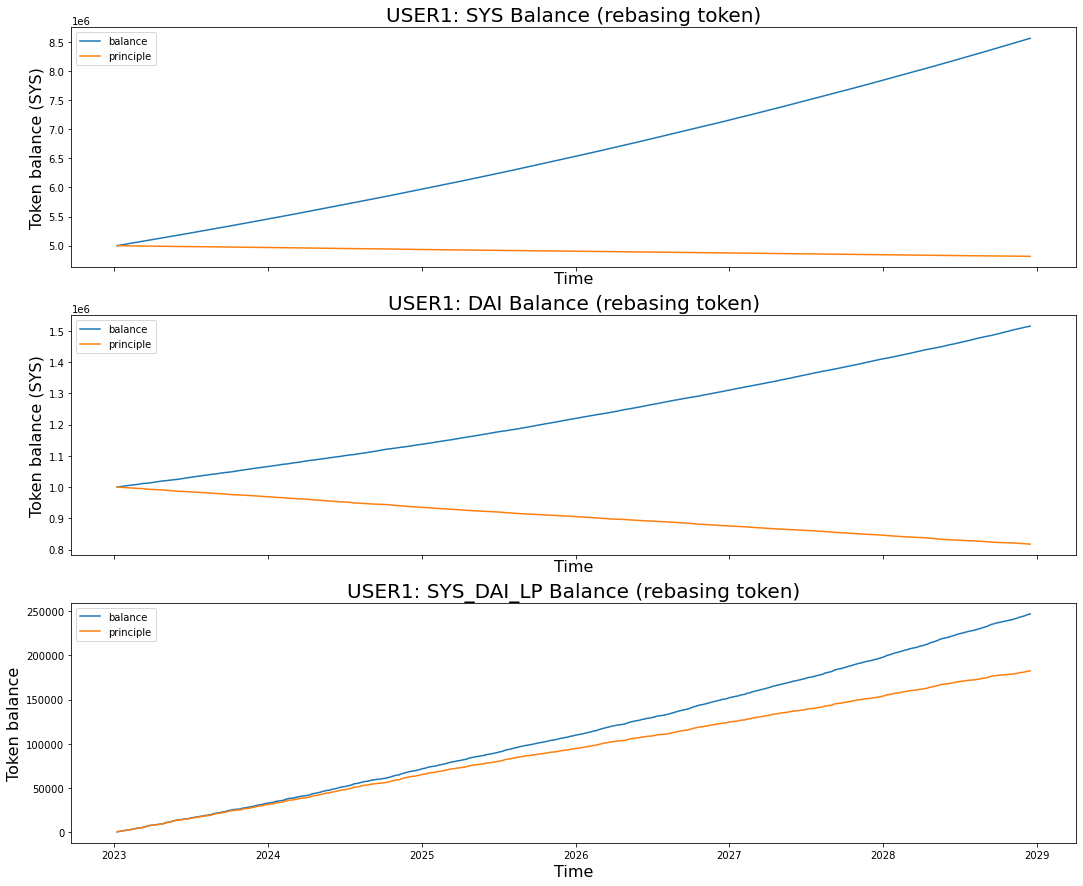

In [22]:
SYS_states1 = tSYS.get_state_series(SYS_addr1)
principle = SYS_states1.get_principle() 
balance = SYS_states1.get_balance() 
tSamp = SYS_states1.get_tstamp()  

fig, (SYS_ax, DAI_ax, SYS_DAI_ax) = plt.subplots(nrows=3, sharex=True, sharey=False, figsize=(18, 15))

SYS_ax.plot(tSamp[1:], balance[1:], label='balance') 
SYS_ax.plot(tSamp[1:], principle[1:], label='principle') 
SYS_ax.set_title("USER1: SYS Balance (rebasing token)", fontsize=20)
SYS_ax.set_ylabel("Token balance (SYS)", fontsize=16)
SYS_ax.set_xlabel('Time', fontsize=16)
SYS_ax.legend()

DAI_states1 = tDAI.get_state_series(DAI_addr1)
principle = DAI_states1.get_principle() 
balance = DAI_states1.get_balance() 
tSamp = DAI_states1.get_tstamp() 

DAI_ax.plot(tSamp[1:], balance[1:], label='balance') 
DAI_ax.plot(tSamp[1:], principle[1:], label='principle') 
DAI_ax.set_title("USER1: DAI Balance (rebasing token)", fontsize=20)
DAI_ax.set_ylabel("Token balance (SYS)", fontsize=16)
DAI_ax.set_xlabel('Time', fontsize=16)
DAI_ax.legend()

SYS_DAI_states1 = tSYS_DAI.get_state_series(SYS_DAI_addr1)
principle = SYS_DAI_states1.get_principle() 
balance = SYS_DAI_states1.get_balance() 
tSamp = SYS_DAI_states1.get_tstamp() 

principle1 = principle
tSamp1 = tSamp

SYS_DAI_ax.plot(tSamp[1:], balance[1:], label='balance') 
SYS_DAI_ax.plot(tSamp[1:], principle[1:], label='principle') 
SYS_DAI_ax.set_title("USER1: SYS_DAI_LP Balance (rebasing token)", fontsize=20)
SYS_DAI_ax.set_ylabel("Token balance", fontsize=16)
SYS_DAI_ax.set_xlabel('Time', fontsize=16)
SYS_DAI_ax.legend()

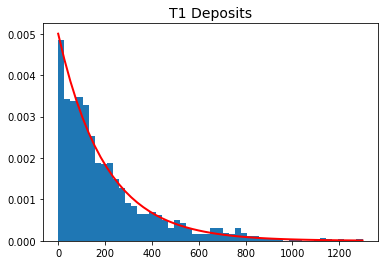

In [23]:
import scipy.special as sps 
max_trade = 1000
shape, scale = 1, max_trade/5  
s = np.random.gamma(shape, scale, 1000)

count, bins, ignored = plt.hist(s, 50, density=True)
y = bins**(shape-1)*(np.exp(-bins/scale) /  
                     (sps.gamma(shape)*scale**shape))
plt.plot(bins, y, linewidth=2, color='r')  
plt.title("T1 Deposits", fontsize=14)
plt.show()

In [24]:
np.random.gamma(shape, scale)

182.80902731293267

In [25]:
from python.dev.cpt import Liquidity

In [26]:
liq = Liquidity(100, 20, 'SYS','DIA')

In [27]:
liq.get_price()

0.19999999999999998

In [28]:
liq.get_y_real()

20

In [29]:
liq.get_x_real()

100

In [30]:
p_arr[1]*liq.get_x_real()

20.08680691923609

In [31]:
p_arr[0:5]

array([0.2       , 0.20086807, 0.19855382, 0.20404242, 0.21074387])

In [32]:
class SimulateLiquidity():
    
    def __init__(self, x_real, y_real, x_name, y_name, max_trade = 1000):       
        self.liq_obj = Liquidity(x_real, y_real, x_name, y_name)
        self.max_trade = max_trade
        self.real_x_arr = np.array([])
        self.real_y_arr = np.array([])        
        self.shape = None
        self.scale = None

    def get_max_trade(self):
        return self.max_trade       
        
    def get_liquidity_obj(self):
        return self.liq_obj
    
    def get_real_x(self):
        return self.real_x_arr
    
    def get_real_y(self):
        return self.real_y_arr    
        
    def set_params(self):
        self.shape, self.scale = 1, self.max_trade/5    
 
    def gen_delta_x(self, p):    
        self.set_params()
        return np.random.gamma(self.shape, self.scale)/p

    def gen_delta_y(self):    
        self.set_params()
        return np.random.gamma(self.shape, self.scale)
    
    def gen_new_position(self, p):
        delta_y = self.gen_delta_y()
        delta_x = (self.liq_obj.get_y_real() + delta_y)/p - self.liq_obj.get_x_real()
        self.liq_obj.add_delta_y(delta_y)
        self.liq_obj.add_delta_x(delta_x)   
        
    def apply(self, p_arr):
        delta_x_arr = np.array([])
        delta_y_arr = np.array([])
        for p in p_arr: 
            self.gen_new_position(p)
            delta_x_arr = np.append(delta_x_arr,self.liq_obj.get_x_delta()) 
            delta_y_arr = np.append(delta_y_arr,self.liq_obj.get_y_delta()) 
            self.real_x_arr = np.append(self.real_x_arr,self.liq_obj.get_x_real()) 
            self.real_y_arr = np.append(self.real_y_arr,self.liq_obj.get_y_real()) 
            
        return delta_x_arr, delta_y_arr    

In [33]:
b = BrownianModel(0.2)
p_arr = b.gen_gbm(0.1, 1, N_RUNS, 1)

sim_liq = SimulateLiquidity(1000, 200, 'SYS','DIA')
x_delta, y_delta = sim_liq.apply(p_arr)

liq = sim_liq.get_liquidity_obj()
liq.get_price()

0.07502216979808096

In [34]:
(p_arr[1]-p_arr[0])/p_arr[0]

0.03400596696978869

In [35]:
def calc_delta_y(x,y,dx,dp):
    return (dp*x**2 + dp*dx*x + dx*y)/x

def calc_delta_x(x,y,dy,dp):
    return (dy*x-dp*x**2)/(dp*x+y)

In [36]:
from scipy.optimize import fsolve

In [37]:
p = 0.2
x = 10000; dx = -36.4955
y = 2000; dy = 20
dp = 0.20273991-0.2

class SolveDeltas():
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.p = y/x
        self.dx = None
        self.dy = None
        self.dp = None
        self.new_p = None
        self.dp_arr = np.array([])
        self.dx_arr = np.array([])
        self.dy_arr = np.array([])
        self.x_arr = np.array([x])
        self.y_arr = np.array([y])
        
    def apply(self, p):
        
        self.dx, self.dy = self.calc_dx_dy(p)
        self.check(p)
        self.x = self.x + self.dx
        self.y = self.y + self.dy
        self.p = p
        self.update(p)
    
    def check(self,p):
        prev_price = self.p
        dp = self.calc_dp(self.dx, self.dy)
        new_price = self.p+dp
        self.dp_arr = np.append(self.dp_arr,dp)
        #print('prev: {:.5f} calc: {:.5f} '.format(prev_price, new_price))
        
    def update(self, p):  
        self.x_arr = np.append(self.x_arr,self.x)
        self.y_arr = np.append(self.y_arr,self.y)
        self.dx_arr = np.append(self.dx_arr,self.dx)
        self.dy_arr = np.append(self.dy_arr,self.dy)
        
    def get_dx(self):
        return self.dx
        
    def get_dy(self):
        return self.dy    
    
    def get_y(self):
        return self.y     
    
    def get_x(self):
        return self.x  
    
    def add_dx(self, dx):
        self.x += dx
        self.p = self.y/self.x
        
    def add_dy(self, dy):
        self.y += dy
        self.p = self.y/self.x
    
    def get_dx_arr(self):
        return self.dx_arr
    
    def get_dy_arr(self):
        return self.dy_arr    
    
    def get_y_arr(self):
        return self.y_arr     
    
    def get_x_arr(self):
        return self.x_arr 
    
    def get_dp_arr(self):
        return self.dp_arr    
            
        
    def func_swap_yx(self, z):
        return [(self.x*abs(z[1]) + abs(z[0])*self.y)/(self.x**2 - abs(z[0])*self.x) - self.dp,
                abs(z[1])/abs(z[0]) - self.new_p]

    def func_swap_xy(self, z):
        return [-(self.x*abs(z[1]) + abs(z[0])*self.y)/(self.x**2 + abs(z[0])*self.x) - self.dp,
                abs(z[1])/abs(z[0]) - self.new_p]

    def calc_dx_dy(self, p):
        self.new_p = p
        self.dp = self.new_p - self.p
        if(self.dp >= 0):
            dx, dy = fsolve(self.func_swap_yx, [1, 1])
            return -dx, dy
        else:
            dx, dy = fsolve(self.func_swap_xy, [1, 1])
            return dx, -dy 

    def calc_dp(self, dx, dy):
        return (self.x*dy - dx*self.y)/(self.x**2 +dx*self.x) 

In [38]:
def add_sub(p):
    return 1 if bool(EventSelectionModel().bi_select(p)) else -1

def delta(p, max_delta=100):
    shape, scale = 1, max_delta/5  
    return add_sub(p)*np.random.gamma(shape, scale)    

In [39]:
dDel = SolveDeltas(10000,2000)
dDel2 = SolveDeltas(10000,2000)

for p in p_arr[1:]:
    dDel.apply(p)
    dDel2.apply(p)
    dx = delta(0.7)
    dDel2.add_dx(dx)
    dy = delta(0.55)
    dDel2.add_dy(dy)

In [40]:
dai_arr = dDel.get_y_arr()
sys_arr = dDel.get_x_arr()
p_calc_arr = abs(dDel.get_dy_arr()/dDel.get_dx_arr())
liq = np.sqrt(dai_arr*sys_arr)

dai_arr2 = dDel2.get_y_arr()
sys_arr2 = dDel2.get_x_arr()
p_calc_arr2 = abs(dDel2.get_dy_arr()/dDel2.get_dx_arr())
liq2 = np.sqrt(dai_arr2*sys_arr2)

In [41]:
N = 1000

raw_price = p_arr[N]
yx_price = dai_arr[N]/sys_arr[N]
dydx_price = p_calc_arr[N-1]
print('raw: {:.7f} y/x: {:.7f} dy/dx: {:.7f} liq: {:.7f}'.format(raw_price, yx_price, dydx_price, liq[N]))

raw_price = p_arr[N]
yx_price = dai_arr2[N]/sys_arr2[N]
dydx_price = p_calc_arr2[N-1]
print('raw: {:.7f} y/x: {:.7f} dy/dx: {:.7f} liq: {:.7f}'.format(raw_price, yx_price, dydx_price, liq2[N]))

raw: 0.1339825 y/x: 0.1339797 dy/dx: 0.1339825 liq: 4800.7663788
raw: 0.1339825 y/x: 0.1339825 dy/dx: 0.1339825 liq: 9031.3067540


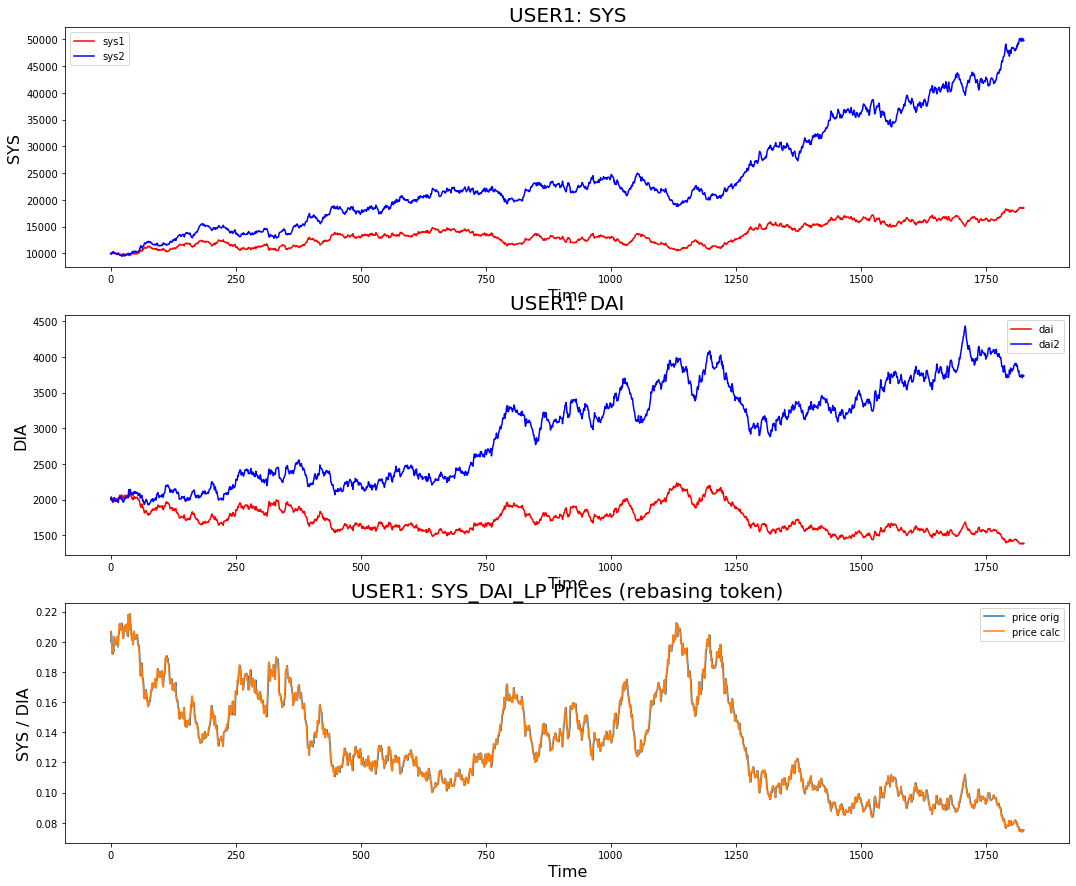

In [42]:
fig, (SYS_ax, DAI_ax, price_ax) = plt.subplots(nrows=3, sharex=False, sharey=False, figsize=(18, 15))
SYS_ax.plot(sys_arr, color = 'r',label='sys1') 
SYS_ax.plot(sys_arr2, color = 'b',label='sys2')
SYS_ax.set_title("USER1: SYS", fontsize=20)
SYS_ax.set_ylabel("SYS", fontsize=16)
SYS_ax.set_xlabel('Time', fontsize=16)
SYS_ax.legend()

DAI_ax.plot(dai_arr, color = 'r', label='dai') 
DAI_ax.plot(dai_arr2, color = 'b', label='dai2') 
DAI_ax.set_title("USER1: DAI", fontsize=20)
DAI_ax.set_ylabel("DIA", fontsize=16)
DAI_ax.set_xlabel('Time', fontsize=16)
DAI_ax.legend()

price_ax.plot(p_arr, label='price orig') 
price_ax.plot(p_calc_arr, label='price calc') 
price_ax.set_title("USER1: SYS_DAI_LP Prices (rebasing token)", fontsize=20)
price_ax.set_ylabel("SYS / DIA", fontsize=16)
price_ax.set_xlabel('Time', fontsize=16)
price_ax.legend()

In [43]:
p_calc_arr[-1]

0.07502216979807905

In [44]:
p_arr[-1]

0.07502216979808096

In [45]:
dai_arr2[-1]/sys_arr2[-1]

0.07502216979808096

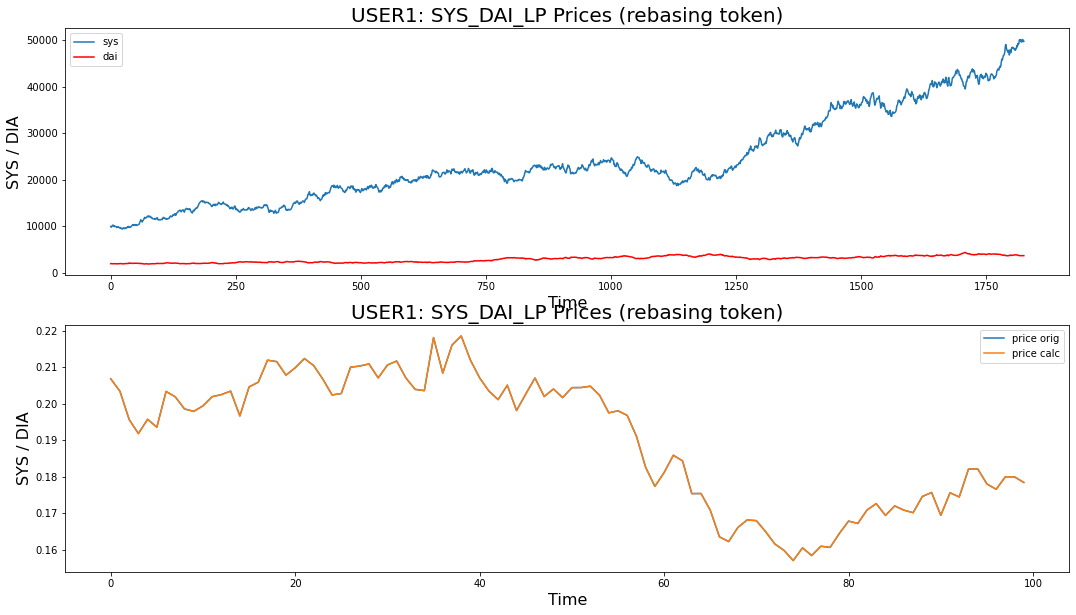

In [46]:
fig, (SYS_DAI_ax, price_ax) = plt.subplots(nrows=2, sharex=False, sharey=False, figsize=(18, 10))
SYS_DAI_ax.plot(sys_arr2, label='sys') 
SYS_DAI_ax.plot(dai_arr2, color = 'r', label='dai') 
SYS_DAI_ax.set_title("USER1: SYS_DAI_LP Prices (rebasing token)", fontsize=20)
SYS_DAI_ax.set_ylabel("SYS / DIA", fontsize=16)
SYS_DAI_ax.set_xlabel('Time', fontsize=16)
SYS_DAI_ax.legend()

price_ax.plot(p_arr[1:101], label='price orig') 
price_ax.plot(p_calc_arr2[0:100], label='price calc') 
price_ax.set_title("USER1: SYS_DAI_LP Prices (rebasing token)", fontsize=20)
price_ax.set_ylabel("SYS / DIA", fontsize=16)
price_ax.set_xlabel('Time', fontsize=16)
price_ax.legend()

* https://stackoverflow.com/questions/30378861/scipy-non-linear-equations-system-with-linear-constraints-beginner

In [47]:
class SolveDeltas2():
    
    def __init__(self, liq):
        self.x = liq.get_x_real()
        self.y = liq.get_y_real()
        self.p = liq.get_price()
        self.dx = liq.get_x_delta()
        self.dy = liq.get_y_delta()
        self.p_prev = self.y/self.x
        self.liq = liq
        self.dp = 0
     
    def apply(self, p):    
        self.dx, self.dy = self.calc_dx_dy(p)
        self.updates(p)
        return self.dx, self.dy
        
    def updates(self, p):
        self.liq.add_delta_x(self.dx)
        self.liq.add_delta_y(self.dy)
        self.p_prev = p
                
    def get_liquidity(self):
        return self.liq   
                    
    def func_swap_yx(self, z):
        return [(self.x*abs(z[1]) + abs(z[0])*self.y)/(self.x**2 - abs(z[0])*self.x) - self.dp,
                abs(z[1])/abs(z[0]) - self.p ]

    def func_swap_xy(self, z):
        return [-(self.x*abs(z[1]) + abs(z[0])*self.y)/(self.x**2 + abs(z[0])*self.x) - self.dp,
                abs(z[1])/abs(z[0]) - self.p ]

    def calc_dx_dy(self, p):
        self.p = p
        self.dp = p - self.p_prev
        self.x = self.liq.get_x_real()
        self.y = self.liq.get_y_real()
        if(self.dp >= 0):
            dx, dy = fsolve(self.func_swap_yx, [1, 1])
            return -dx, dy
        else:
            dx, dy = fsolve(self.func_swap_xy, [1, 1])
            return dx, -dy

In [48]:
liq = Liquidity(10000, 2000, 'SYS','DIA')
sDel = SolveDeltas2(liq)
sDel2 = SolveDeltas(10000, 2000)

sys_arr = np.array([])
dia_arr = np.array([])
dsys_arr = np.array([])
ddia_arr = np.array([])

for p in p_arr[1:]:
    swap_dx, swap_dy = sDel.apply(p)
    sDel2.apply(p)
    #liq.add_delta_x(swap_dx)
    #liq.add_delta_y(swap_dy)
    sys_arr = np.append(sys_arr, liq.get_x_real())
    dia_arr = np.append(dia_arr, liq.get_y_real())
    dsys_arr = np.append(dsys_arr, liq.get_x_delta())
    ddia_arr = np.append(ddia_arr, liq.get_y_delta())    
    #dx = delta(0.7)
    #dDel2.add_dx(dx)
    #dy = delta(0.55)
    #dDel2.add_dy(dy)
    #print('dx: {:.7f} dy: {:.7f}'.format(sDel2.get_dx(), sDel2.get_dy()))
    #print('dx`: {:.7f} dy`: {:.7f}\n'.format(swap_dx, swap_dy))
        
    
     

In [56]:
N = 1500

raw_price = p_arr[N]
yx_price = dai_arr[N]/sys_arr[N]
dydx_price = abs(ddia_arr[N-1]/dsys_arr[N-1])
print('raw: {:.7f} y/x: {:.7f} dy/dx: {:.7f}'.format(raw_price, yx_price, dydx_price))

raw: 0.0942290 y/x: 0.0935341 dy/dx: 0.0942290


In [50]:
def gen_delta_y(max_trade = 10):    
    shape, scale = 1, max_trade/5 
    return np.random.gamma(shape, scale)
    #return 100

def gen_delta_x(p, max_trade = 10):    
    shape, scale = 1, max_trade/5 
    return np.random.gamma(shape, scale)/p
    #return 100/p
    
def per_chg(p_arr, k):
    return (p_arr[k]-p_arr[k-1])/p_arr[k-1]



print(p_arr[0:5])

liq_obj = Liquidity(10000, 2000, 'SYS','DIA')
x_arr = np.array([])
y_arr = np.array([])
x_delta_arr = np.array([])
y_delta_arr = np.array([])

for k in range(1,len(p_arr)):
    p = p_arr[k]
    inc = increase_y[k-1]
    x = liq_obj.get_x_real()
    y = liq_obj.get_y_real()
    dp = dp_arr[k-1]
    if(increase_y[k-1]):
        #delta_y = gen_delta_y()
        #delta_x = (liq_obj.get_y_real() + delta_y)/p - liq_obj.get_x_real()
        dy = 0.01*y
        dx = calc_delta_x(x,y,dy,dp)      
    else:    
        #delta_x = gen_delta_x(p)
        #delta_y = p*delta_x + p*liq_obj.get_x_real() - liq_obj.get_y_real() 
        dx = 0.01*x
        dy = calc_delta_y(x,y,dx,dp)
    
    liq_obj.add_delta_y(dy)
    liq_obj.add_delta_x(dx)  
    x_real = liq_obj.get_x_real()
    y_real = liq_obj.get_y_real()
    
    x_arr = np.append(x_arr, x_real)
    y_arr = np.append(y_arr, y_real)
    x_delta_arr = np.append(x_delta_arr, dx)
    y_delta_arr = np.append(y_delta_arr, dy)    

    print('[inc y: {}],   \u0394y {:.2f}, \u0394x {:.2f}'.format(inc, dy, dx))
    print('[p:     {:.4f}]   y {:.2f},  x {:.2f}\n'.format(y_real/x_real, y_real, x_real))
    


[0.2        0.20680119 0.20339783 0.19565192 0.1918185 ]


NameError: name 'increase_y' is not defined

In [ ]:
x_real = sim_liq.get_real_x()
y_real = sim_liq.get_real_y()

fig, (p_ax, liq_ax, d_ax) = plt.subplots(nrows=3, sharex=False, sharey=False, figsize=(18, 15))

p_ax.plot(p_arr, label='SYS/DAI') 
p_ax.set_title("Price", fontsize=20)
p_ax.set_xlabel('Time', fontsize=16)
p_ax.legend()

liq_ax.plot(x_arr, label='SYS') 
liq_ax.plot(y_arr, label='DIA') 
liq_ax.set_title("Token balances", fontsize=20)
liq_ax.set_xlabel('Time', fontsize=16)
liq_ax.legend()

d_ax.plot(x_delta_arr, label='SYS_delta') 
d_ax.plot(y_delta_arr, label='DIA_delta') 
d_ax.set_title("Price", fontsize=20)
d_ax.set_xlabel('Time', fontsize=16)
d_ax.legend()

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.neighbors import KernelDensity

class KDE():
    
    def __init__(self, kernel='gaussian'):
        self.__kernel = kernel
        self.__kde = None
        self.__samp = None

    def fit(self, y_arr, bw=0.01):
        self.__samp = y_arr
        self.__kde = KernelDensity(bandwidth=bw, kernel = self.__kernel)
        self.__kde.fit(self.__samp.reshape([-1,1]))           
        
    def sample(self, N):
        eval_pnts = np.linspace(np.min(self.__samp), np.max(self.__samp))
        return eval_pnts, self.__kde.sample(N)  
    
    def get_pdf_est(self):
        eval_pnts = np.linspace(np.min(self.__samp), np.max(self.__samp))
        return np.exp(self.__kde.score_samples(eval_pnts.reshape(-1,1)))    
        
    def get_kde(self):
        return self.__kde

In [ ]:
kde_x = KDE()
xfit = kde_x.fit(x_delta_arr, bw=40)

kde_y = KDE()
yfit = kde_y.fit(y_delta_arr, bw=40)

y_kde_est = kde_y.get_pdf_est()
y_pnts, y_kde_samp = kde_y.sample(1000)

x_kde_est = kde_x.get_pdf_est()
x_pnts, x_kde_samp = kde_x.sample(1000)

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(15, 10))
ax1.plot(y_pnts, y_kde_est, c='g')
ax1.hist(y_kde_samp, bins=100, density=True, color='r', alpha=0.7)

ax2.plot(x_pnts, x_kde_est, c='g')
ax2.hist(x_kde_samp, bins=100, density=True, color='r', alpha=0.7)

plt.show()

In [ ]:
x = np.array([])
x = np.append(x,1)
x

In [ ]:
sim_liq = SimulateLiquidity(1000, 200, 'SYS','DIA')

liq = sim_liq.get_liquidity_obj()
liq.calc()
liq.get_price()

In [ ]:
liq = Liquidity(1000, 200, 'SYS','DIA')

In [ ]:
delta_y = np.random.gamma(shape, scale)
delta_x = (liq.get_y_real() + delta_y)/p_arr[1] - liq.get_x_real()
liq.add_delta_y(delta_y)
liq.add_delta_x(delta_x)
#liq.calc()
#liq.get_price()

In [ ]:
delta_y = np.random.gamma(shape, scale)
delta_x = (liq.get_y_real() + delta_y)/p_arr[2] - liq.get_x_real()
liq.add_delta_y(delta_y)
liq.add_delta_x(delta_x)
#liq.calc()
#liq.get_price()

In [ ]:
delta_y = np.random.gamma(shape, scale)
delta_x = (liq.get_y_real() + delta_y)/p_arr[3] - liq.get_x_real()
liq.add_delta_y(delta_y)
liq.add_delta_x(delta_x)
liq.calc()
liq.get_price()

In [ ]:
liq.get_x_real()

In [ ]:
liq.get_y_real()

In [ ]:
liq.get_price()

In [ ]:
liq.add_delta_y(delta_y)
liq.add_delta_x(delta_x)
liq.calc()
liq.get_price()

In [ ]:
liq.get_x_real()

In [ ]:
y_new = 10

(liq.get_x_real()*y_new)/(liq.get_y_real()+y_new)


In [ ]:
30/133

In [ ]:
liq.get_y_real()

In [ ]:
liq = Liquidity(100, 20, 'SYS','DIA')

In [ ]:
delta_y = (p_arr[1]-p_arr[0])*liq.get_x_real() 
liq.add_delta_y(delta_y)
liq.calc()
liq.get_price()

In [ ]:
liq.get_x_real()

In [ ]:
delta_y = (p_arr[2]-p_arr[1])*liq.get_x_real()
liq.add_delta_y(delta_y)
liq.calc()
liq.get_price()

In [ ]:
delta_y = (p_arr[3]-p_arr[2])*liq.get_x_real()
liq.add_delta_y(delta_y)
liq.calc()
liq.get_price()

In [ ]:
liq.get_y_real()

In [ ]:
liq.get_x_real()

In [ ]:
p_arr[0:5]

In [ ]:
#SYS_DAI_LP_prices[1:]

In [ ]:
SYS_DAI_LP = SYS_DAI.get_lp().get_lp_events()
SYS_DAI_LP_prices = SYS_DAI_LP.get_prices()
SYS_DAI_LP_dates = SYS_DAI_LP.get_dates()

fig, (SYS_DAI_ax) = plt.subplots(nrows=1, sharex=True, sharey=False, figsize=(18, 5))
SYS_DAI_ax.plot(SYS_DAI_LP_dates[1:], 1/SYS_DAI_LP_prices[1:], label='prices') 
SYS_DAI_ax.plot(SYS_DAI_LP_dates[1:], p_arr[2:], color = 'r', label='prices') 

SYS_DAI_ax.set_title("USER1: SYS_DAI_LP Prices (rebasing token)", fontsize=20)
SYS_DAI_ax.set_ylabel("SYS / DIA", fontsize=16)
SYS_DAI_ax.set_xlabel('Time', fontsize=16)
SYS_DAI_ax.legend()

In [ ]:
#orchestrator.print_logs()

In [ ]:
SYS_DAI_LP.get_event(1).get_liquidity().get_y_real()

In [ ]:
SYS_DAI_LP.get_event(1).get_liquidity().get_x_real()

In [ ]:
SYS_DAI_LP.get_event(1).get_liquidity().get_price()

In [ ]:
SYS_DAI_LP.get_event(3).get_liquidity().get_liquidity_val()

In [ ]:
#b = BrownianModel(0.2)
#p_arr = b.gen_gbm(0.1, 1, 365, 1)
#xy_arr = gen_xy_arr(p_arr, 100)